In [1]:
import time
import blosc2 as b2
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt

In [2]:
# A tomography-like array: a stack of 2D images (greyscale).
# Each image corresponds to a chunk in the array.
shape = (10, 25600, 19200)
dtype = np.dtype('u2')
# shape = (100, 256, 256)  # for tests
chunkshape = (1, *shape[1:])
clevel = 5
# The next can be set as environment variables or directly here.
# To select the compressor, and compression level for the regular HDF5 Blosc2 filter
os.environ["BLOSC_CLEVEL"] = str(clevel)
os.environ["BLOSC_COMPRESSOR"] = "zstd"
# You can play with different filters here (NOSHUFFLE/SHUFFLE/BITSHUFFLE)
#os.environ["BLOSC_SHUFFLE"] = "SHUFFLE"
# You can set the number of threads for Blosc
#os.environ['BLOSC_NTHREADS'] = str(b2.nthreads)

In [3]:
# Blosc2 blockshape cannot be specified via `tb.Filters` because the interface is
# not ready for passing it yet, so to compare apples with apples, avoid using it.
# However, you may want to experiment with different blockshapes with direct chunking.
# b2_blockshape = (1, *tuple(d // 2 for d in chunkshape[1:]))  # 4 blocks per chunk
# b2_blockshape = (1, 800, 600)  # around 1 MB per block
# blocksize = np.prod(b2_blockshape) * dtype.itemsize
# print("Blocksize:", blocksize, b2_blockshape)
# Use the next line to set the blocksize for regular I/O.  Unfortunately, this is not
# compatible with a multidim blockshape in direct chunking (we are sending different
# requirements to the Blosc2 library), so better don't use it.
# os.environ['BLOSC_BLOCKSIZE'] = str(blocksize)

In [4]:
# The 'image' dataset that will be (repeatedly) stored in the HDF5 file.
np_data = (np.arange(np.prod(chunkshape), dtype=dtype)
           .reshape(chunkshape))

# The measured speeds
speeds = {}

### Direct chunking

Let's start by creating a new HDF5 file using direct chunking.  The procedure is as follows:
1. Create an extendable array.
2. Grow the array to the final size.
3. Create the compressed data chunk (cframe).
4. Write the compressed data chunk by chunk.

In [5]:
fname = 'direct-chunking.h5'
with (tb.open_file(fname, mode='w') as h5f):
    array = h5f.create_earray(
        '/', 'array',
        atom=tb.Atom.from_dtype(dtype),
        shape=(0, *shape[1:]),
        # Setting both args tells others that data is compressed using Blosc2,
        # and it should not be handled as plain data.
        filters=tb.Filters(complevel=clevel, complib='blosc2'),
        chunkshape=chunkshape,
    )

    # First, grow the array without actually storing data.
    array.truncate(shape[0])
    # Now, do store the data as raw chunks.
    coords_tail = (0,) * (len(shape) - 1)

    def do_write():
        for c in range(shape[0]):
            # The same image/chunk will be written over and over again.
            b2_data = b2.asarray(np_data, chunks=chunkshape,
                                 cparams=dict(clevel=clevel))
            wchunk = b2_data.to_cframe()
            chunk_coords = (c,) + coords_tail
            array.write_chunk(chunk_coords, wchunk)
    start = time.time()
    do_write()  # cProfile.run('do_write()')
    elapsed = time.time() - start
    speed = np.prod(shape) * dtype.itemsize / elapsed / 1e6
    print(f"[direct chunking] Wrote {shape[0]} chunks in ({elapsed:.3} s)."
          f" Speed: {speed:.2f} MB/s.")
    speeds['direct'] = {} 
    speeds['direct']['write'] = speed

[direct chunking] Wrote 10 chunks in (5.71 s). Speed: 1722.51 MB/s.


Now, let's read the data back.

The procedure is as follows:

1. Read the compressed data chunk.
2. Decompress the data chunk.
3. Read the data into a numpy array from the decompressed data chunk.
4. Repeat for all chunks.

In [6]:
with tb.open_file(fname, mode='r') as h5f:
    array = h5f.root.array

    coords_tail = (0,) * (len(shape) - 1)
    def do_read():
        tsize = 0
        for c in range(shape[0]):
            chunk_coords = (c,) + coords_tail
            rchunk = array.read_chunk(chunk_coords)
            ndarr = b2.ndarray_from_cframe(rchunk)
            np_data2 = ndarr[:]
            tsize += np_data2.size
        return tsize * dtype.itemsize
    start = time.time()
    tsize = do_read()
    elapsed = time.time() - start
    assert tsize == np.prod(shape) * dtype.itemsize
    speed = np.prod(shape) * dtype.itemsize / elapsed / 1e6
    print(f"[direct chunking] Read {shape[0]} chunks of {tsize/2**20} MB ({elapsed:.3} s)."
          f" Speed: {speed:.2f} MB/s.")
    speeds['direct']['read'] = speed

[direct chunking] Read 10 chunks of 9375.0 MB (1.9 s). Speed: 5172.77 MB/s.


## Regular chunking

Let's now create a new HDF5 file using regular chunking.  The procedure is as follows:
1. Create an extendable array, using Blosc2 as a compressor.
2. Grow the array to the final size.
3. Write the data chunk by chunk (the HDF5 pipeline will call Blosc2 automatically).

In [7]:
fname2 = 'regular-chunking.h5'
with tb.open_file(fname2, mode='w') as h5f:
    array = h5f.create_earray(
        '/', 'array',
        atom=tb.Atom.from_dtype(dtype),
        shape=(0, *shape[1:]),
        # Setting both args tells others that data is compressed using Blosc2,
        # and it should not be handled as plain data.
        filters=tb.Filters(complevel=clevel, complib='blosc2'),
        chunkshape=chunkshape,
    )

    # First, grow the array without actually storing data.
    array.truncate(shape[0])
    # Now, do store the data as raw chunks.
    coords_tail = (0,) * (len(shape) - 1)

    def do_write():
        for c in range(shape[0]):
            # The same image/chunk will be written over and over again.
            array[c] = np_data
    start = time.time()
    do_write()  # cProfile.run('do_write()')
    elapsed = time.time() - start
    speed = np.prod(shape) * dtype.itemsize / elapsed / 1e6
    print(f"[regular chunking] Wrote {shape[0]} chunks in ({elapsed:.3} s)."
          f" Speed: {speed:.2f} MB/s.")
    speeds['regular'] = {}
    speeds['regular']['write'] = speed

[regular chunking] Wrote 10 chunks in (21.5 s). Speed: 458.24 MB/s.


Now, let's read the data back.

The procedure is as follows:

1. Read the compressed data chunk. The HDF5 pipeline will call Blosc2 automatically for decompression.
2. Repeat for all chunks.

In [8]:
with tb.open_file(fname2, mode='r') as h5f:
    array = h5f.root.array

    coords_tail = (0,) * (len(shape) - 1)
    def do_read():
        tsize = 0
        for c in range(shape[0]):
            np_data2 = array[c]
            tsize += np_data2.size
        return tsize * dtype.itemsize
    start = time.time()
    tsize = do_read()  # cProfile.run('do_read()')
    elapsed = time.time() - start
    assert tsize == np.prod(shape) * dtype.itemsize
    speed = np.prod(shape) * dtype.itemsize / elapsed / 1e6
    print(f"[regular chunking] Read {shape[0]} chunks of {tsize/2**20} MB ({elapsed:.3} s)."
          f" Speed: {tsize / elapsed / 1e6:.2f} MB/s.")
    speeds['regular']['read'] = speed

[regular chunking] Read 10 chunks of 9375.0 MB (8.35 s). Speed: 1176.62 MB/s.


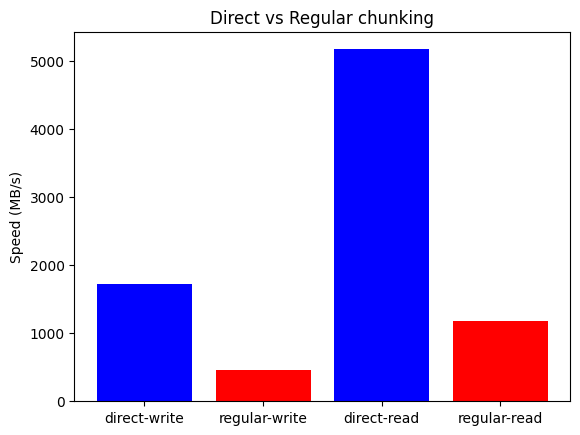

In [9]:
# Plot the results
fig, ax = plt.subplots()
#ax.bar(speeds.keys(), speeds.values())
ax.bar('direct-write', speeds['direct']['write'], label='Direct write', color='b')
ax.bar('regular-write', speeds['regular']['write'], label='Regular write', color='r')
ax.bar('direct-read', speeds['direct']['read'], label='Direct read', color='b')
ax.bar('regular-read', speeds['regular']['read'], label='Regular read', color='r')
ax.set_ylabel('Speed (MB/s)')
ax.set_title('Direct vs Regular chunking')
plt.show()

## Discussion

As we can see, direct chunking offers immediate speed benefits for both writing and reading.  The reason is that we are bypassing the HDF5 pipeline for dealing with chunked data, and we are directly using the Blosc2 library for that.  This is particularly beneficial for large datasets, where the overhead of the HDF5 pipeline can be very significant.

Note that, if you are careful, and you use a cframe for serializing the data with the direct chunking method, the resulting HDF5 file can still be decompressed with any HDF5-enabled application, as long as it has the Blosc2 filter available.  Fortunately, the [hdf5plugin](https://hdf5plugin.readthedocs.io/en/stable/#) comes with the Blosc2 filter, so you can use it in your Python applications without any problem.

Finally, as the direct chunking allows for more direct interaction with the Blosc2 library, you can experiment with different blockshapes, compressors, filters and compression levels, to find the best configuration for your specific needs.  In particular, as [Blosc2 supports multidimensional double partitioning](https://www.blosc.org/posts/blosc2-ndim-intro/), you may want to try with different blockshapes to see if you can get better performance for your specific data access pattern.